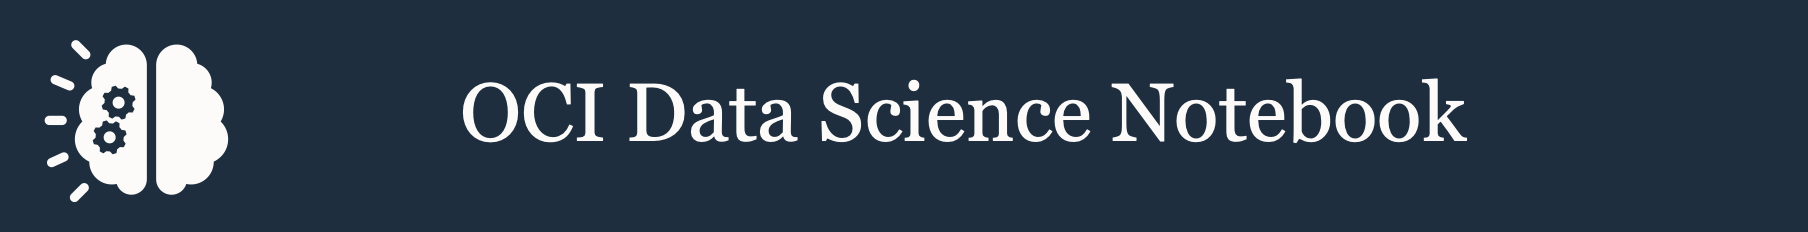

</br>
<h1 style='color:#1a2f40'> Oracle AI Vector Search </h1>

**<span style='color:#1a2f40'>Authors:**</span> Douglas Hood & Ismail Syed</br>
**<span style='color:#1a2f40'>Company:**</span> Oracle
</br></br>

**<span style='color:#1a2f40'>Description:**</span> In this notebook we will explore how we can using the `oracledb` python SDK to interact with the Oracle Database 23ai EE with AI Vector Search Capabilities. We have created a table `simple_demo_cohere` within our Oracle Database and loaded 89 rows of sample text data into this table. Please refer to the SQL script `simple-demo-cohere-dataloading.sql` for the table creation and data loading statements which can be executed against our Oracle DB via SQLPlus or SQLDeveloper.

The following Notebook will go through reading in our sample data, then using the new Langchain integration to call the OCI Generative AI and perform Embeddings on top of text data utilising the `cohere.embbed-english.v3.0` model (we will pass each text as its own API embed call), and store the data back into our table via an update statement. We can then perform similarity search against our Vector DB to find the closest matched records based on our input data.

**<span style='color:#1a2f40'>Pre-Requisites:**</span>
* Install oracledb `pip install oracledb --upgrade`
* Install tqdm `pip install tqdm`
* Install ADS 2.9.1 `pip install oracle-ads --upgrade`
* Install OCI Preview `pip install oci --upgrade`
* Install Langchain `pip install langchain --upgrade`
* Install Langchain Community `pip install langchain-community --upgrade`
* Resource Principal or OCI API Keys Configured


</br><h3 style='color:#1a2f40'>Imports</h3>

In [1]:
import os
import array
import oracledb
import tqdm
import oci
import numpy as np
from dotenv import load_dotenv
from langchain_community.embeddings import OCIGenAIEmbeddings

</br><h3 style='color:#1a2f40'>Establish Connection to Oracle DB</h3>

In [2]:
# Load Environment Variables
if load_dotenv('.env'):
    print('Environment Variables Loaded Successfully.')
else:
    print('Environment Variables Failed to Load.')

Environment Variables Loaded Successfully.


In [3]:
# Establish Connect to Oracle DB
connection = oracledb.connect(user=os.environ.get("DB_USER"), 
                              password=os.environ.get("DB_PASSWORD"), 
                              dsn=os.environ.get("DB_DSN"))

In [4]:
# Establish Cursor to get data
cursor1 = connection.cursor()

# Establish Cursor to update data
cursor2 = connection.cursor()

</br><h3 style='color:#1a2f40'>Retrieve Data</h3>

In [5]:
# Retrieve Data from our table
cursor1.execute("""
                select id, text
                from simple_demo_cohere
                order by 1
                """)

<oracledb.Cursor on <oracledb.Connection to ismail@130.61.27.55:1521/vectordb_pdb1.sub05070940350.datasciencevcn.oraclevcn.com>>

</br><h3 style='color:#1a2f40'>Configure GenAI Embedding Model</h3>

In [6]:
# Only available for Chicago Region
ENDPOINT = "https://inference.generativeai.us-chicago-1.oci.oraclecloud.com"

# Define Model Name
MODEL_NAME = "cohere.embed-english-v3.0"

# Define Compartment
COMPARTMENT_ID = "<compartment-id>"

In [7]:
# Instantiate OCI Gen AI Model
embed_model = OCIGenAIEmbeddings(
    model_id = MODEL_NAME,
    service_endpoint = ENDPOINT,
    compartment_id= COMPARTMENT_ID,
    auth_type='API_KEY',
    auth_profile='CHICAGO')

</br><h3 style='color:#1a2f40'>Vectorize & Write Data Back to DB</h3>

In [8]:
# Set Counter
count = 0

# Extract Data - List
rows = cursor1.fetchall()

In [9]:
# Iterate over each row
for row in tqdm.tqdm(rows):
    
    # Get PK Value
    id_val = row[0]
    
    # Extract Text to into List for Sentence Transformer
    data = [row[1]]
    
    # Send the text to Cohere Embed v3 Model and get back a vector as a list
    vec = embed_model.embed_documents(data)[0]
        
    # Convert Vector to Array
    vec_array = array.array('d', vec)
    
    # Execute Update Statement to add or replace the vector values
    cursor2.execute('update simple_demo_cohere set text_v = :1 where id = :2', [vec_array, id_val])
    
    # Increment Counter
    count += 1
    
    
# Commit Updates
connection.commit()

# Print Number of Updates
print("\nAdded " + str(count) + " vectors to the table.")

100%|██████████| 89/89 [00:11<00:00,  8.01it/s]


Added 89 vectors to the table.


</br><h3 style='color:#1a2f40'>Query Vectorized Data</h3>

In [10]:
# Retrieve first 1 Row of Data from our table
cursor1.execute("""
                select id, text, text_v
                from simple_demo_cohere
                order by id
                fetch first 1 rows only
                """)

# Extract Data - List
rows = cursor1.fetchall()

# Print Data
for row in rows:
    
    print('ID:', row[0])
    print('\nSentence:', row[1])
    print('\nLength of Embedding:', len(list(row[2])))
    print('\nVector Embedding:', list(row[2]))

ID: 1

Sentence: San Francisco is in California.

Length of Embedding: 1024

Vector Embedding: [0.0138168335, 0.009735107, -0.02178955, -0.022521973, -0.023757935, -0.021942139, -0.045715332, -0.013671875, -0.010047913, 0.0029411316, -0.049041748, -0.0045928955, -0.048858643, 0.0005311966, 0.020141602, -0.01486969, 0.037841797, -0.029022217, -0.022491455, -0.010627747, -0.015136719, 0.02104187, -0.028503418, -0.02798462, 0.05142212, 0.0022449493, -0.07495117, 0.008430481, 0.044921875, 0.012756348, 0.0047950745, -0.0064048767, 0.022521973, -0.0026741028, 0.0025081635, 0.026321411, -0.0011253357, -0.008270264, 0.005279541, 0.025497437, 0.0051116943, -0.009178162, -0.013381958, -0.0146102905, -0.036254883, -0.033813477, 0.032318115, 0.0007920265, 0.011734009, -0.036621094, -0.0053482056, -0.06427002, 0.014190674, -0.025756836, -0.06585693, -0.03164673, -0.03427124, -0.005874634, 0.010696411, -0.003692627, 0.0032196045, 0.026275635, 0.015068054, 0.027908325, -0.019729614, -0.007007599, 0.0

</br><h3 style='color:#1a2f40'>Similarity Search</h3>

In [11]:
# Define SQL Query
sql_query = 'select text from simple_demo_cohere order by vector_distance(text_v, :1, DOT) fetch first 3 rows only'

# Define Sample Query
input_text = ['Fast and reliable car']

In [12]:
# Create the embedding and extract the vector
input_vec = embed_model.embed_documents(input_text)[0]

# Convert to Array
input_array = array.array('d', input_vec)

In [13]:
# Do the Similarity Search
cursor1.execute(sql_query, [input_array])

# Extract Data - List
rows = cursor1.fetchall()

# Print Results
print(f'Top 3 Matches to Input: {input_text[0]}\n')
for row in rows:
    print(row[0])

Top 3 Matches to Input: Fast and reliable car

Toyotas are reliable.
Hondas are reliable.
Porsches are fast and reliable.


</br><h3 style='color:#1a2f40'>Close Connection</h3>

In [14]:
# Close Connection
connection.close()
print("\nDisconnected from Oracle database")


Disconnected from Oracle database


</br></br><center><h1 style='color:#1a2f40'>End of Notebook</h1></center>